In [ ]:
!unzip /content/drive/MyDrive/darknet.zip

In [ ]:
%cd /content/darknet
!make
! chmod +x ./darknet

In [ ]:
!sudo apt install dos2unix

In [ ]:

!dos2unix ./data/train.txt
!dos2unix ./data/val.txt
!dos2unix ./data/yolo.data
!dos2unix ./data/yolo.names
!dos2unix ./cfg/yolov3_custom_train.cfg

dos2unix: converting file ./data/train.txt to Unix format...
dos2unix: converting file ./data/val.txt to Unix format...
dos2unix: converting file ./data/yolo.data to Unix format...
dos2unix: converting file ./data/yolo.names to Unix format...
dos2unix: converting file ./cfg/yolov3_custom_train.cfg to Unix format...


In [ ]:
!./darknet detector train data/yolo.data cfg/yolov3_custom_train.cfg yolov3_900.weights     #I had interrupted training, it take very long

yolov3_custom_train
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 ^C


In [ ]:
#!rm /content/darknet/backup -r
#!ln -s /content/drive/My Drive/YOLOv3_weight/backup /content/darknet

In [34]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)
    

In [36]:
labelsPath = os.path.join("/content/darknet/data/yolo.names")
LABELS = open(labelsPath).read().strip().split("\n")

In [37]:
LABELS

['Guns']

In [ ]:
!cp /content/yolo_custom_test.cfg /content/darknet/cfg

In [38]:
weightsPath = os.path.join("/content/darknet/yolov3_900.weights")
configPath = os.path.join("/content/darknet/cfg/yolo_custom_test.cfg")

In [39]:
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

In [49]:
def predict(image):
    
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = (0,128,0)     #check the RGB codes and change it accordingly
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    return image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


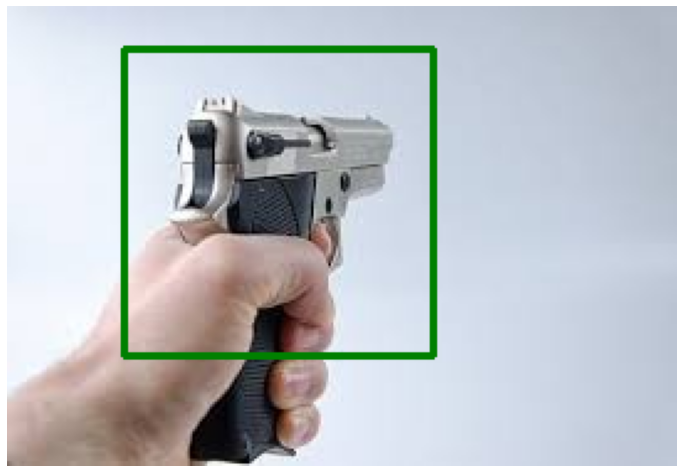

In [50]:
# Execute prediction on a single image
img = cv2.imread("/content/images1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

In [ ]:
##trying with a clip_FAIL!!! :(
#cap =cv2.VideoCapture('Roberry.mp4')

#number_frame = 30.0 #higher frames better quality of the video
#video_size = (1280,720)
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#out = cv2.VideoWriter('gun_detection.mp4',fourcc, number_frame,video_size)

#while True:
    #ret,frame = cap.read() 
    
    #if ret:
        
        #frame = cv2.resize(frame, (1280,720))
        #frame = predict(frame)
        #cv2.imshow("image",frame)
        #out.write(frame)

        #if cv2.waitKey(1) & 0xff == ord("q"):
            #break
    #else:
        #break
        
#cap.release()   
#out.release()
#cv2.destroyAllWindows()